# Data Preparation
> Fake data generation and artificial gaps for GPFA

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp data_preparation

In [ ]:
#| export
import torch
from torch import Tensor

import pandas as pd
import numpy as np
from fastcore.foundation import patch
from fastcore.test import *
from fastcore.basics import *

import matplotlib.pyplot as plt
import altair as alt
from altair import datum

from functools import lru_cache
from typing import Collection

In [ ]:
torch.manual_seed(277); # set seed for reproducibility of examples

## Data generator 

generate some fake data in order to test the imputation

What is does is:
- take a function to generate the "true" latent
- use some random coefficient to generate all the N features
- add some random noise

In [ ]:
#| exports
class GPFADataGenerator:
    def __init__(self,
                    n_features: int,
                    n_obs: int,
                    latent_func = lambda x: torch.sin(3*x), # Functions used to generate the true latent
                    noise_std = .2,
                    Lambda = None
                ):
        
        self.n_features, self.n_obs = n_features, n_obs
        self.time = torch.arange(0, self.n_obs, dtype=torch.float)
        
        self.latent = latent_func(self.time)
        
        self.Lambda = torch.tensor(Lambda).reshape(n_features, 1) if Lambda is not None else torch.rand(n_features, 1)
        
        self.exact_X = (self.Lambda * self.latent).T
        
        self.X =  self.exact_X + torch.normal(0., noise_std, size = (n_obs, n_features)) 
        
        self.data = pd.DataFrame(self.X.numpy(), columns = [f"x{i}" for i in range(self.n_features)]) 
        

In [ ]:
fdg = GPFADataGenerator(3, 4)

In [ ]:
fd_plot = pd.DataFrame(fdg.X.numpy(), columns = ["x1", "x2", "x3"])
fd_plot["latent"] = pd.Series(fdg.latent.numpy())

<AxesSubplot: >

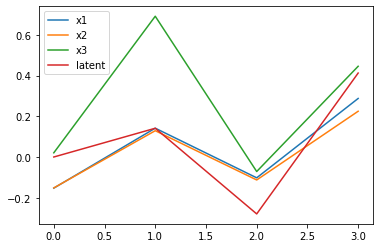

In [ ]:
fd_plot.plot()

## Missing Data

In [ ]:
#| exports
class MeteoDataTest:
    "Utility class to keep track of dataset, missing data and export to right format"
    def __init__(self, data: pd.DataFrame):
        " Init with provided dataset"
        self.data = data.copy()
        self.data_complete = self.data.copy()
        self.n_features, self.n_obs = data.shape[1], data.shape[0]
        self.time = torch.arange(0, self.n_obs, dtype=torch.float)
    @classmethod
    def generate_gpfa(cls, *args, **kwargs):
        generator = GPFADataGenerator(*args, **kwargs)
        self = MeteoDataTest(generator.data)
        self.generator = generator
        return self

### Missing Data

generate artificial gaps in the data

#### Missing at Random

In [ ]:
#| exports
@patch()
def add_random_missing(self: MeteoDataTest,
                       prob_miss_row: float = .2,  #  Probability an entire row is missing
                       prob_miss_value: float = .1  # Probability a single observation is missing
                       ):
    """Make some row and same values randomly missing """
    # keep the original data
        
    self.is_miss_row = torch.rand(self.n_obs) <= prob_miss_row
    
    self.data[self.is_miss_row.numpy()] = np.nan
    
    self.is_miss_value = (torch.rand(self.n_obs * self.n_features) <= prob_miss_value).reshape(-1, self.n_features)
    
    self.data[self.is_miss_value.numpy()] = np.nan
    
    return self

In [ ]:
fd = MeteoDataTest.generate_gpfa(3, 4)

In [ ]:
fd.add_random_missing().data

,x0,x1,x2
0,-0.001938,-0.127557,NaN
1,NaN,NaN,NaN
2,0.137062,0.151774,-0.092625
3,NaN,NaN,NaN


In [ ]:
MeteoDataTest.generate_gpfa(2, 10).add_random_missing(prob_miss_value = .7, prob_miss_row=.0).data

,x0,x1
0,-0.203655,-0.117674
1,NaN,NaN
2,NaN,-0.111792
3,NaN,NaN
4,NaN,NaN
5,NaN,0.112875
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,0.409263


#### Continous gap

The missing data is all clustered around a gap

parameteres:
- gap length
- variable for gap


In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int = None # Optional start of gap
): # (total_length) array of bools to indicicate if the data is missing or not
    "Add a continous gap of ginve length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
_make_random_gap(3, 10)

array([False, False, False, False, False,  True,  True,  True, False,
       False])

In [ ]:
test_eq(_make_random_gap(3, 10).sum(), 3) # correct gap length

In [ ]:
#| exports
@patch
def add_gap(self: MeteoDataTest,
            gap_length:int,  # length of gap
            variables: Collection[str],  # variables that should be affected by the gap
            gap_start: int = None  # Optional start of the gap
            ):
    
    
    self.is_gap = _make_random_gap(gap_length, self.data.shape[0], gap_start)
    self.data.loc[self.is_gap, variables] = np.nan
    return self

In [ ]:
MeteoDataTest.generate_gpfa(5, 10).add_gap(4, ["x1", "x2"]).data

,x0,x1,x2,x3,x4
0,0.147414,-0.162167,0.534020,-0.314157,-0.145421
1,0.227970,-0.250645,-0.280364,0.298646,0.023241
2,-0.277233,NaN,NaN,0.011927,0.350378
3,0.081553,NaN,NaN,0.091917,0.162622
4,-0.488591,NaN,NaN,-0.383358,-0.142712
5,0.850323,NaN,NaN,0.378259,-0.198052
6,-0.554473,-0.438560,-0.345700,-0.368945,-0.081258
7,0.904893,0.390038,0.473491,0.916413,-0.053904
8,-0.463149,-0.567804,-0.318116,-0.687993,0.118367
9,0.931138,0.398865,0.561607,0.701557,0.026598


### Save as DataFrame

In [ ]:
#| exports
@patch
def tidy_df(self: MeteoDataTest,
            complete = False,  # full dataset (False) or the one with missing data (True)
            is_missing = False  # add flag whether value is missing
            ):
    
    df = self.data if not complete else self.data_complete # no need to copy here because next lines does a copy anyway
    df = df.assign(time = self.time.numpy())
        
    df = df.melt("time")
    
    if is_missing: df = df.assign(is_missing = self.data.melt().value.isna()) #missing data is not from complete data
        
    return df

In [ ]:
fd.tidy_df()

,time,variable,value
0,0.0,x0,-0.001938
1,1.0,x0,NaN
2,2.0,x0,0.137062
3,3.0,x0,NaN
4,0.0,x1,-0.127557
5,1.0,x1,NaN
6,2.0,x1,0.151774
7,3.0,x1,NaN
8,0.0,x2,NaN
9,1.0,x2,NaN


In [ ]:
fd.tidy_df(complete=True)

,time,variable,value
0,0.0,x0,-0.001938
1,1.0,x0,0.021966
2,2.0,x0,0.137062
3,3.0,x0,0.031551
4,0.0,x1,-0.127557
5,1.0,x1,0.295225
6,2.0,x1,0.151774
7,3.0,x1,0.116207
8,0.0,x2,0.139568
9,1.0,x2,0.029323


In [ ]:
fd.tidy_df(complete=False, is_missing=True)

,time,variable,value,is_missing
0,0.0,x0,-0.001938,False
1,1.0,x0,NaN,True
2,2.0,x0,0.137062,False
3,3.0,x0,NaN,True
4,0.0,x1,-0.127557,False
5,1.0,x1,NaN,True
6,2.0,x1,0.151774,False
7,3.0,x1,NaN,True
8,0.0,x2,NaN,True
9,1.0,x2,NaN,True


The export as a dataframe is working correctly with the missing data

In [ ]:
fd_df = fd.tidy_df()

In [ ]:
alt.Chart(fd_df).mark_line(point=True).encode(
    x = "time",
    y = "value",
    color = "variable"
)

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
fd.data

,x0,x1,x2
0,-0.001938,-0.127557,NaN
1,NaN,NaN,NaN
2,0.137062,0.151774,-0.092625
3,NaN,NaN,NaN


In [ ]:
#| export
@patch(as_prop=True)
def data_compl_tidy(self: MeteoDataTest):
    return self.tidy_df(complete=True, is_missing=True)

In [ ]:
fd.data_compl_tidy

,time,variable,value,is_missing
0,0.0,x0,-0.001938,False
1,1.0,x0,0.021966,True
2,2.0,x0,0.137062,False
3,3.0,x0,0.031551,True
4,0.0,x1,-0.127557,False
5,1.0,x1,0.295225,True
6,2.0,x1,0.151774,False
7,3.0,x1,0.116207,True
8,0.0,x2,0.139568,True
9,1.0,x2,0.029323,True


## Standard Scaler

The different variables in the can have pretty different values so we standardize so they are more comparable. Have numbers between 0 and 1 should also help with the computation accuracy.

One additional complexity is the need to backtransform not only the mean but also the standard deviation.

So we need a but of math

$$x_{norm} = \frac{x - \mu_x}{\sigma_x}$$
then
$$x = x_{norm}\sigma_x + \mu_x $$

using properties of Guassian distributions ^[https://cs.nyu.edu/~roweis/notes/gaussid.pdf eq. 4a]

$$p(x_{norm}) = \mathcal{N}(\mu_{norm}, \sigma^2_{norm})$$

$$p(x) = \mathcal{N}(\sigma_x\mu_{norm} + \mu_x, \sigma^2_x \sigma^2_{norm})$$

In [ ]:
#| export
def _nanstd_1dim(x):
    """ equivalent to `torch.std(x, axis=0)` with the support for `nan`"""
    mean = torch.nanmean(x, 0)
    var = (x - mean)**2
    length = (~var.isnan()).sum(0) 
    # sample std so need to divide my n-1
    return torch.sqrt(torch.nansum(var, 0)/(length - 1))

In [ ]:
#| export

class StandardScaler:
    def __init__(self,
                 x: Tensor # up to 2D Tensor
                ):
        """Init normalizer by storing mean and std dev"""
        self.x_mean = torch.nanmean(x, axis=0)
        self.x_std = _nanstd_1dim(x)
        
    def transform(self,
        x: Tensor # up to 2D tensor 
                 ) -> Tensor: # x_normalized
        "Normalize (substract mean and divide by standard deviation) input tensor"
        return ((x - self.x_mean) / self.x_std)

    def inverse_transform(self,
        x_norm, # Normalized array
                          ) -> Tensor:       # Array after reversing normalization
        return x_norm * self.x_std + self.x_mean

    def inverse_transform_std(self,
        x_std_norm, # Normalized array of standard deviations
                          ) -> Tensor:       # Array after reversing normalization
        return x_std_norm * self.x_std

In [ ]:
x = torch.randn(20).reshape(-1,2)
norm = StandardScaler(x)
test_close(x, norm.inverse_transform(norm.transform(x)))
test_close(x.std(axis=0), norm.inverse_transform_std(norm.transform(x).std(axis=0)))

In [ ]:
nx = x.clone()
nx[3] = torch.nan
StandardScaler(nx).transform(nx)

tensor([[ 1.0434, -0.7018],
        [-0.3413, -0.2264],
        [ 0.7216, -0.9768],
        [    nan,     nan],
        [ 0.3866,  0.1091],
        [-1.5779,  0.1705],
        [ 0.1036, -1.2577],
        [-1.6543,  1.3312],
        [ 0.7548,  1.7514],
        [ 0.5635, -0.1993]])

## Log transform

In [ ]:
#| export
@patch
def log_transform(self: MeteoDataTest,
                  vars: str | Collection[str],  # list of variables names to log-transform
                  )-> MeteoDataTest:
    "Tranform the given var with log(x+1)"
    for var in listify(vars):
        self.data["log_" + var] = np.log(self.data[var] + 1)
        self.data_complete["log_" + var] = np.log(self.data_complete[var] + 1)
    self.data = self.data.drop(columns=vars)
    self.data_complete = self.data_complete.drop(columns=vars)
    return self

In [ ]:
MeteoDataTest.generate_gpfa(3, 4).log_transform(['x1']).data

,x0,x2,log_x1
0,-0.209523,0.137226,0.221309
1,0.308402,0.304317,0.229732
2,-0.079178,-0.082795,-0.302681
3,0.218236,0.400733,0.326986


In [ ]:
orig_data = MeteoDataTest.generate_gpfa(1, 200)

orig_data.data = np.abs(orig_data.data)

data = orig_data.log_transform(['x0'])

array([[<AxesSubplot: title={'center': 'log_x0'}>]], dtype=object)

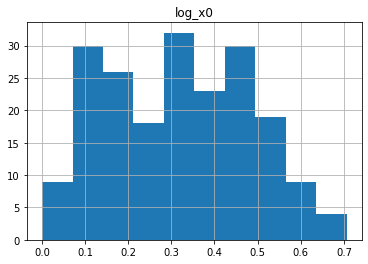

In [ ]:
data.data.hist()

## Export

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()